In [16]:
# Imports

import os
import bioread
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from scipy.stats import spearmanr

In [17]:
# Define number of subject (s = 1, 2, 3), number of intervention (i = 1, 2, 3, 4), and cut (starting time of intervention)

s = 1
i = 1
cut = 323

# Pipeline for Data Analysis

-	For 1 subject and 1 intervention
-	Output: 40 correlation values
-	Includes parts that are introduced below

# Blood pressure

-	1 signal
-	Signal is cleaned from NaN values
-   Cutted the signal according to timestamp

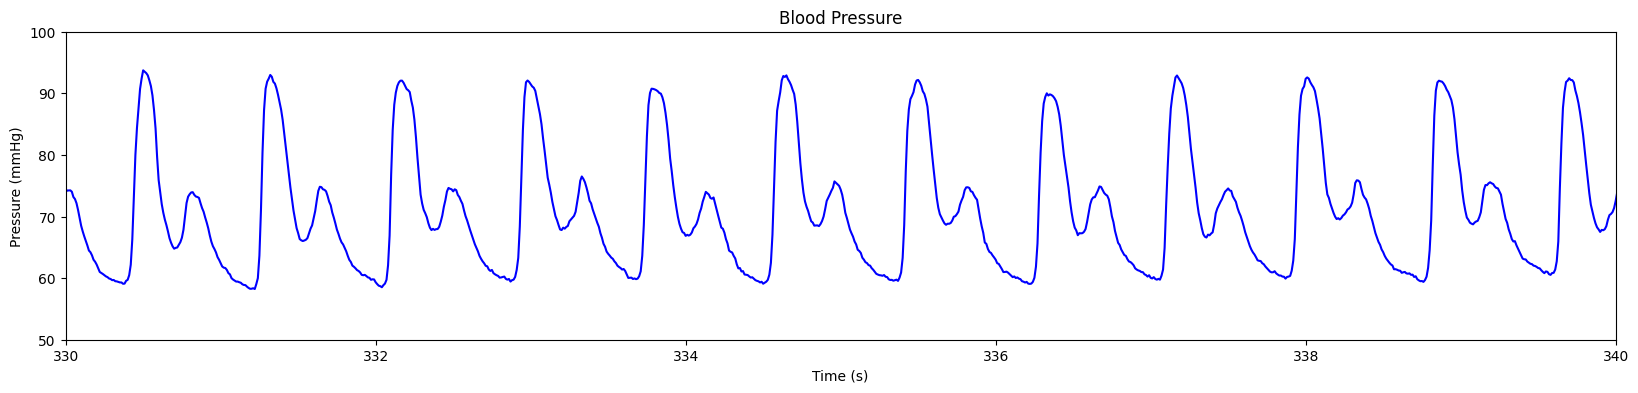

In [18]:
# Signals
waveform = pd.read_csv(f's{s}_i{i}_bp_waveform.csv', sep=';', skipinitialspace=True)
beats = pd.read_csv(f's{s}_i{i}_bp_beats.csv', sep=';', skipinitialspace=True)

# Signal is cleaned from NaN values
waveform.dropna(subset=['Pressure [mmHg]'], inplace=True)
beats.dropna(subset=['Beat Sys [mmHg]', 'Beat Mean [mmHg]', 'Beat Dia [mmHg]'], inplace=True)

# Cutting the signal
start_time = cut

# Filter the waveform according to cut
waveform_cut = waveform[waveform['Time [s]'] >= start_time]

# Plotting the cut waveform
plt.figure(figsize=(20, 4))
plt.plot(waveform_cut['Time [s]'], waveform_cut['Pressure [mmHg]'], color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
# Scaling (change according to signal)
plt.xlim(330, 340)
plt.ylim(50, 100)
plt.title("Blood Pressure")
plt.show()

# Electroencephalography

-	2 signals, first represents potential between electrodes AF7 and AF8, second represents potential between electrodes TP9 and TP10
-	Filtering is already done in AcqKnowledge software
-   Cutted the signal according to timestamp

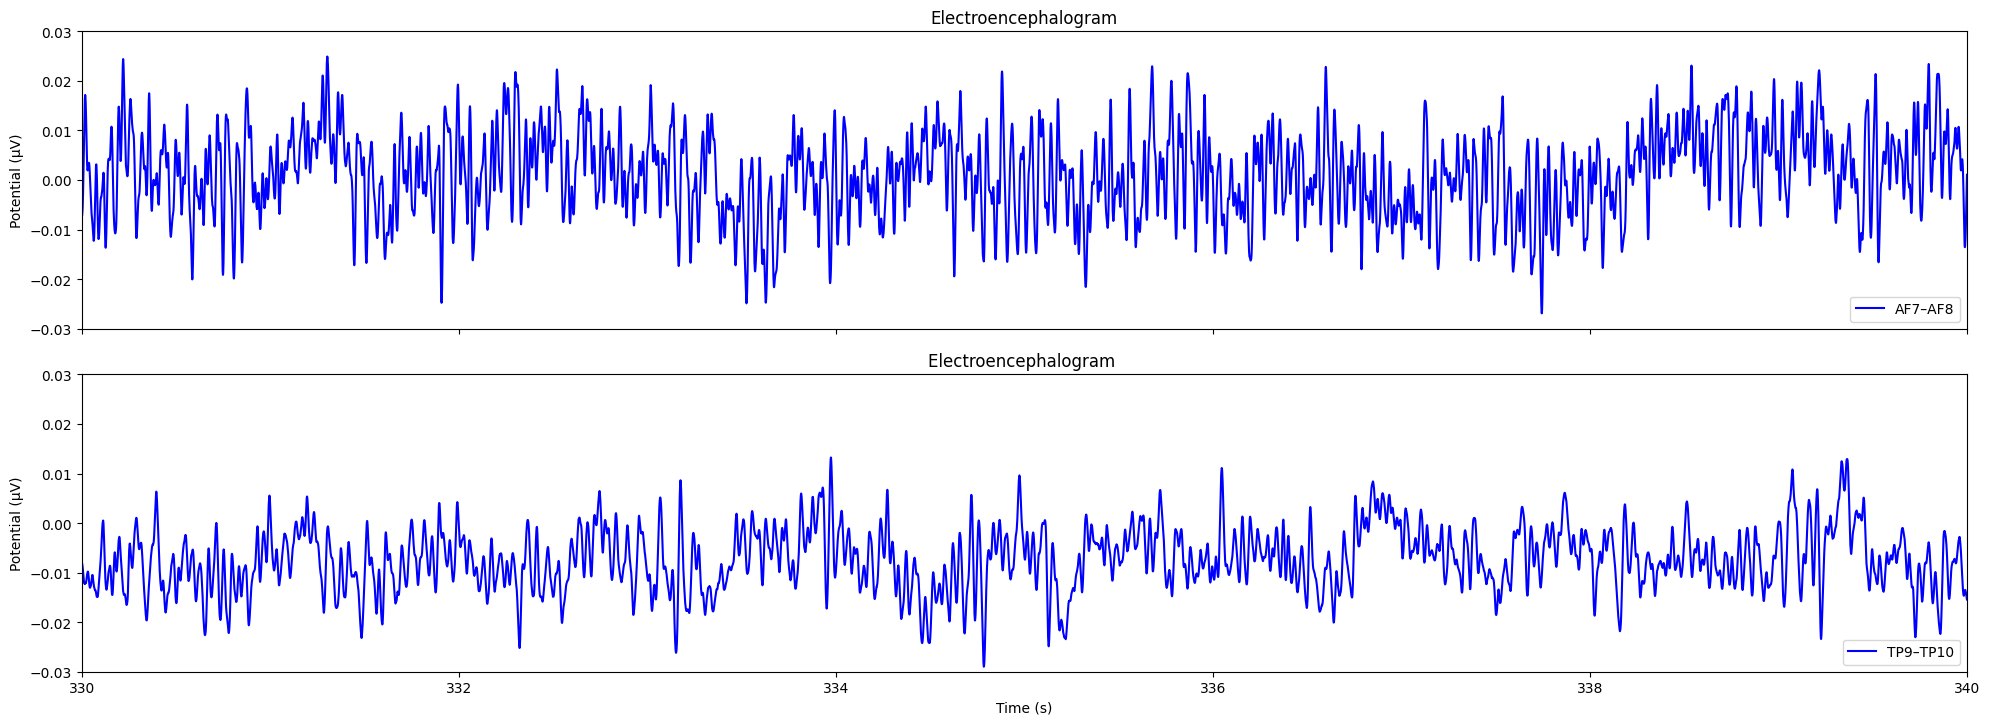

In [19]:
# File path
file_path = f"s{s}_i{i}_eeg.acq"

# Read the file
data = bioread.read_file(file_path)

# Extract channels
channel_1 = data.channels[0]
channel_2 = data.channels[1]

# Cutting the signal
start_time = cut
channel_1_cut = channel_1.data[channel_1.time_index >= start_time]
channel_2_cut = channel_2.data[channel_2.time_index >= start_time]
time_index_1_cut = channel_1.time_index[channel_1.time_index >= start_time]
time_index_2_cut = channel_2.time_index[channel_2.time_index >= start_time]

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

# Plot the first channel
axs[0].plot(time_index_1_cut, channel_1_cut, label="AF7–AF8", color="blue")
axs[0].set_ylabel("Potential (µV)")
axs[0].set_title("Electroencephalogram")
axs[0].legend(loc="lower right")
# Scaling (change according to signal)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_xlim(330, 340)

# Plot the second channel
axs[1].plot(time_index_2_cut, channel_2_cut, label="TP9–TP10", color="blue")
axs[1].set_ylabel("Potential (µV)")
axs[1].set_title("Electroencephalogram ")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Time (s)")
# Scaling (change according to signal)
axs[1].set_ylim(-0.03, 0.03)
axs[1].set_xlim(330, 340)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Variables

-	BP signal has 4 variables: 1) BP 2) BP sys 3) BP dia 4) BP mean
-	EEG signal has 5 variables: 1) EEG 2) EEG delta 3) EEG theta 4) EEG alpha 5) EEG beta 
-	EEG variables are differentiated with frequency-domain bandpass filter
-	Total of 2 EEG signals, so total of 10 EEG variables

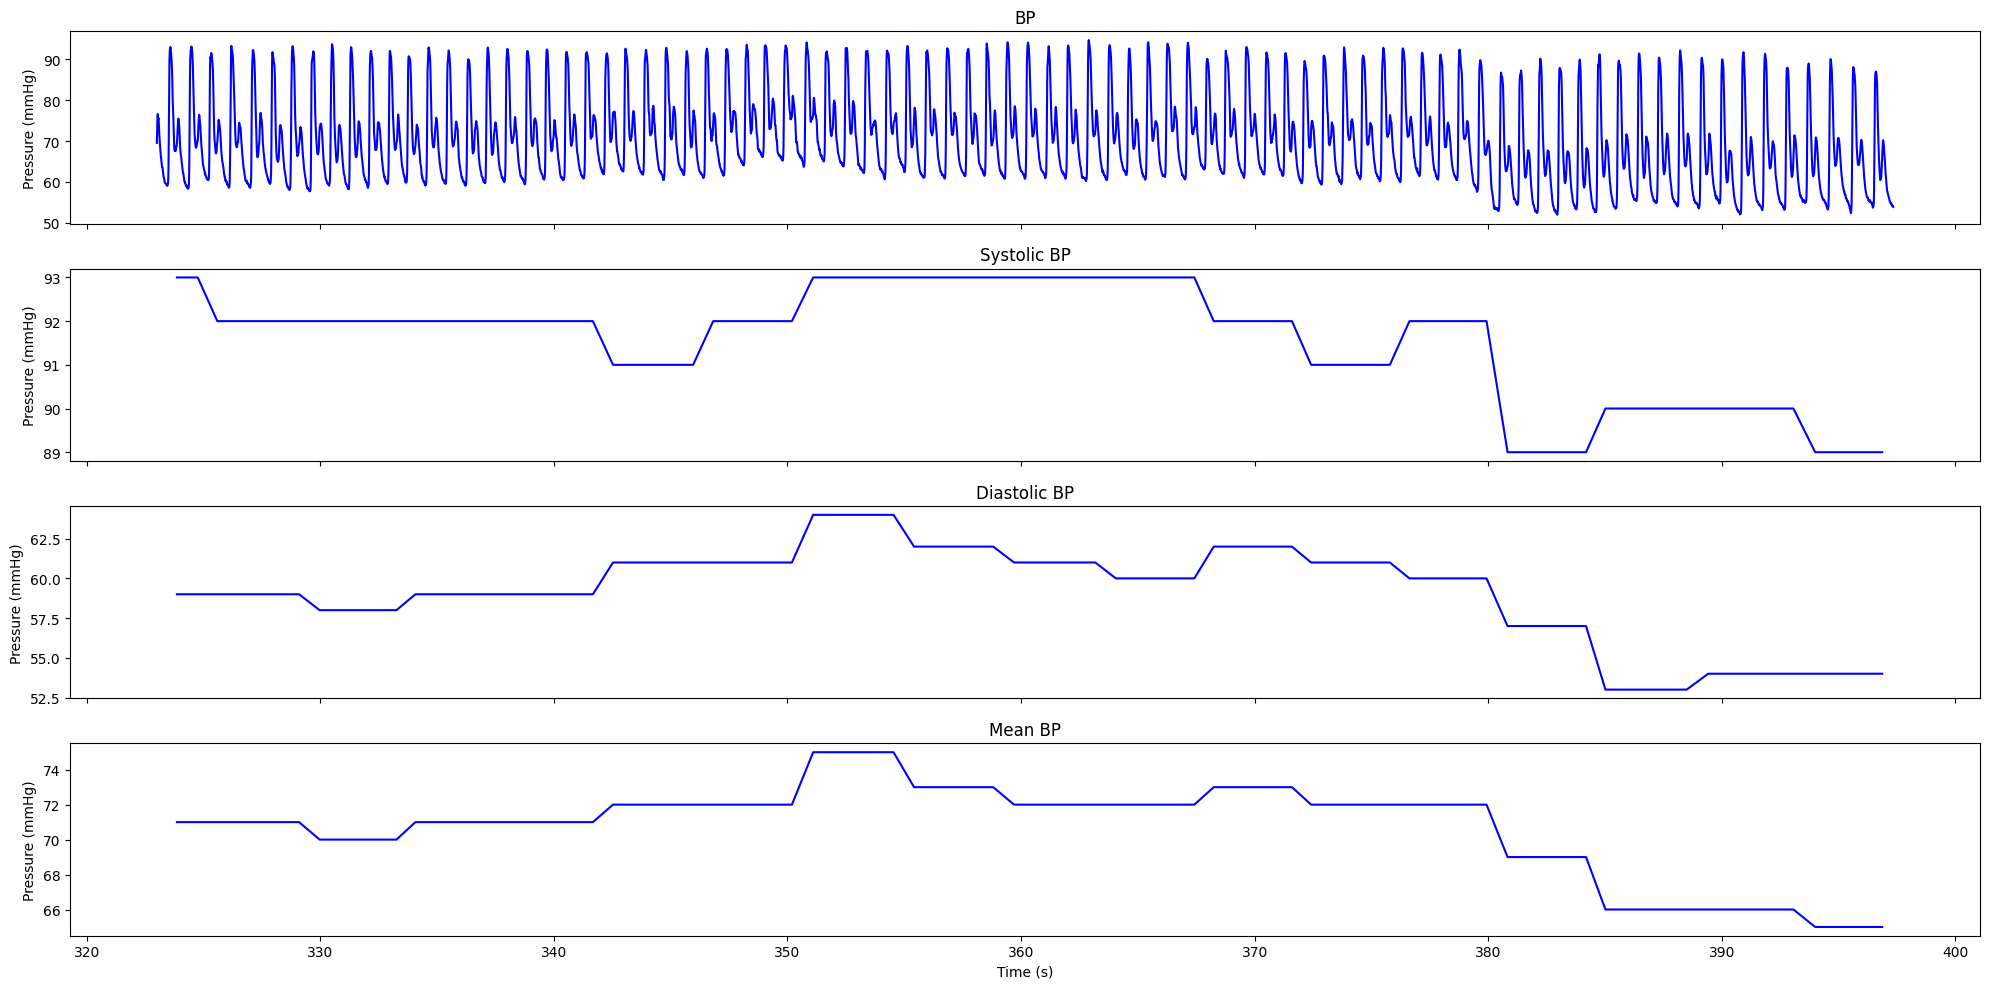

In [20]:
# Signals
waveform = pd.read_csv(f's{s}_i{i}_bp_waveform.csv', sep=';', skipinitialspace=True)
beats = pd.read_csv(f's{s}_i{i}_bp_beats.csv', sep=';', skipinitialspace=True)

# Signal is cleaned from NaN values
waveform.dropna(subset=['Pressure [mmHg]'], inplace=True)
beats.dropna(subset=['Beat Sys [mmHg]', 'Beat Mean [mmHg]', 'Beat Dia [mmHg]'], inplace=True)

# Cutting the signal
start_time = cut

# Filter the waveform and beats according to cut
waveform_cut = waveform[waveform['Time [s]'] >= start_time]
beats_cut = beats[beats['Time [s]'] >= start_time]

# Creating BP variables for the cut signal
bp = waveform_cut['Pressure [mmHg]']
bp_sys = beats_cut['Beat Sys [mmHg]']
bp_dia = beats_cut['Beat Dia [mmHg]']
bp_mean = beats_cut['Beat Mean [mmHg]']

# List of the BP variables
bp_variables = [
    bp,
    bp_sys,
    bp_dia,
    bp_mean
]

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

# Plot BP
axs[0].plot(waveform_cut['Time [s]'], bp, color='blue')
axs[0].set_title('BP')
axs[0].set_ylabel('Pressure (mmHg)')

# Plot Systolic BP
axs[1].plot(beats_cut['Time [s]'], bp_sys, color='blue')
axs[1].set_title('Systolic BP')
axs[1].set_ylabel('Pressure (mmHg)')

# Plot Diastolic BP
axs[2].plot(beats_cut['Time [s]'], bp_dia, color='blue')
axs[2].set_title('Diastolic BP')
axs[2].set_ylabel('Pressure (mmHg)')

# Plot Mean BP
axs[3].plot(beats_cut['Time [s]'], bp_mean, color='blue')
axs[3].set_title('Mean BP')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Pressure (mmHg)')

plt.tight_layout()
plt.show()

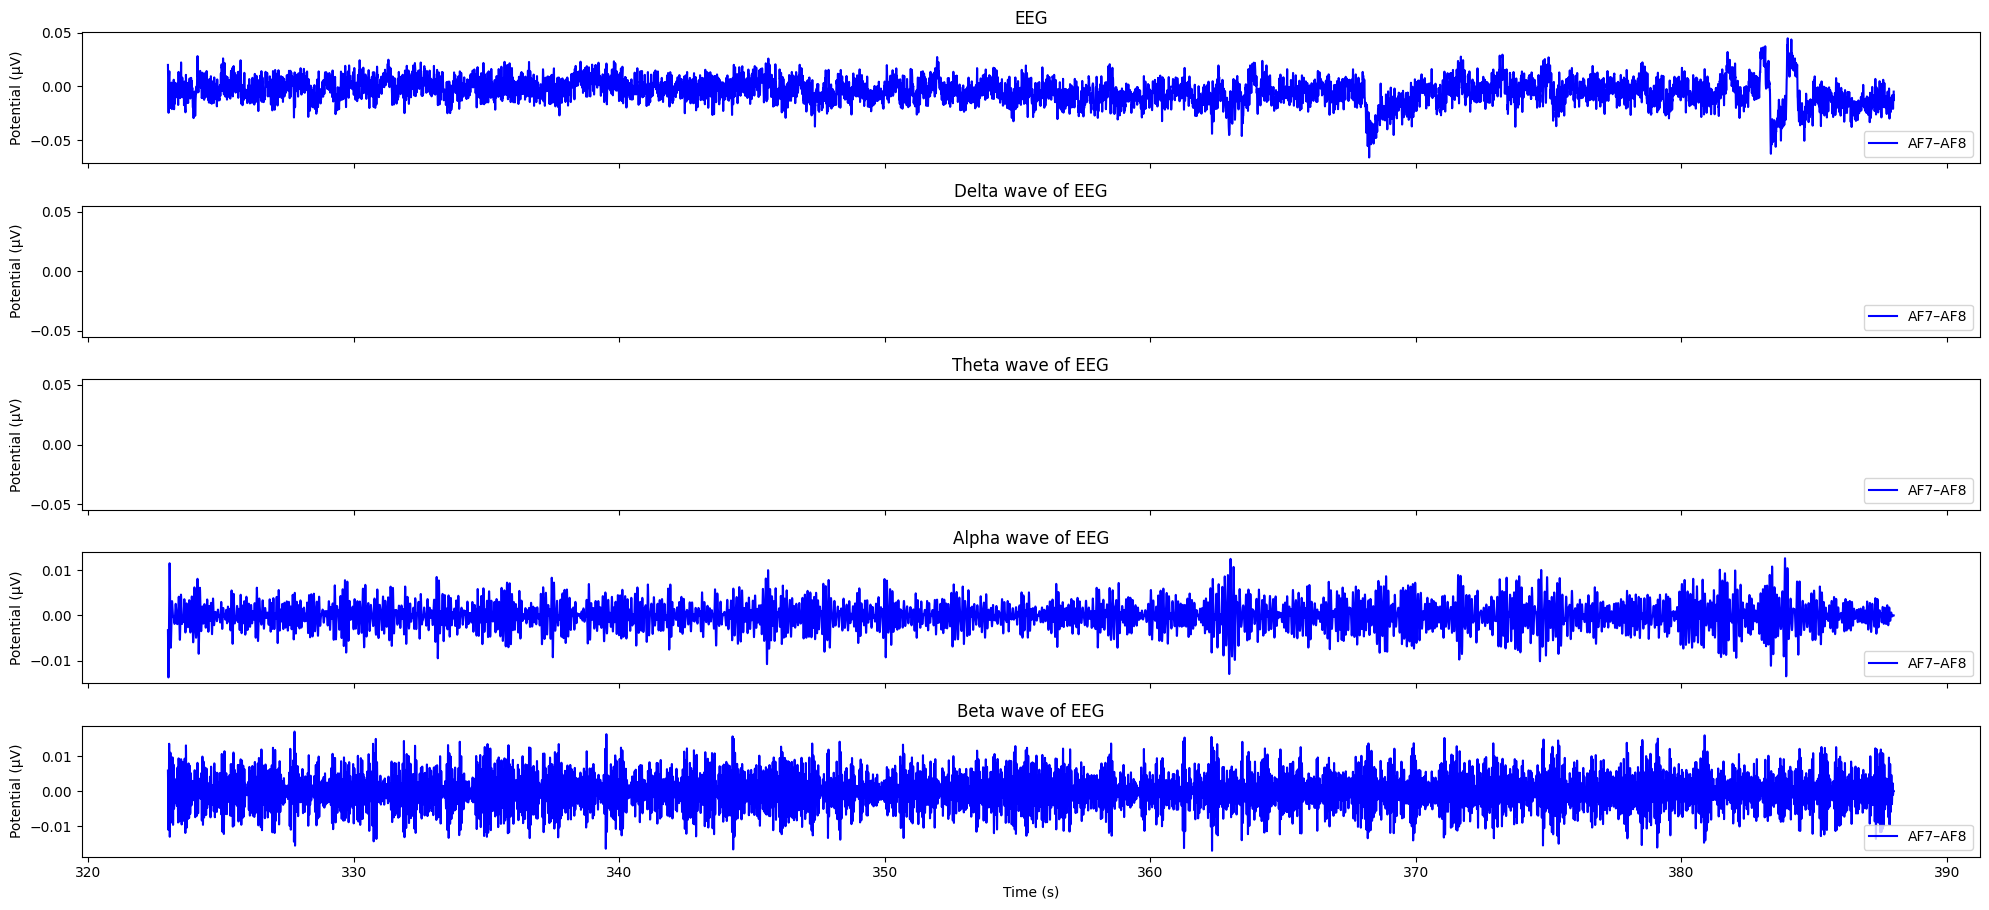

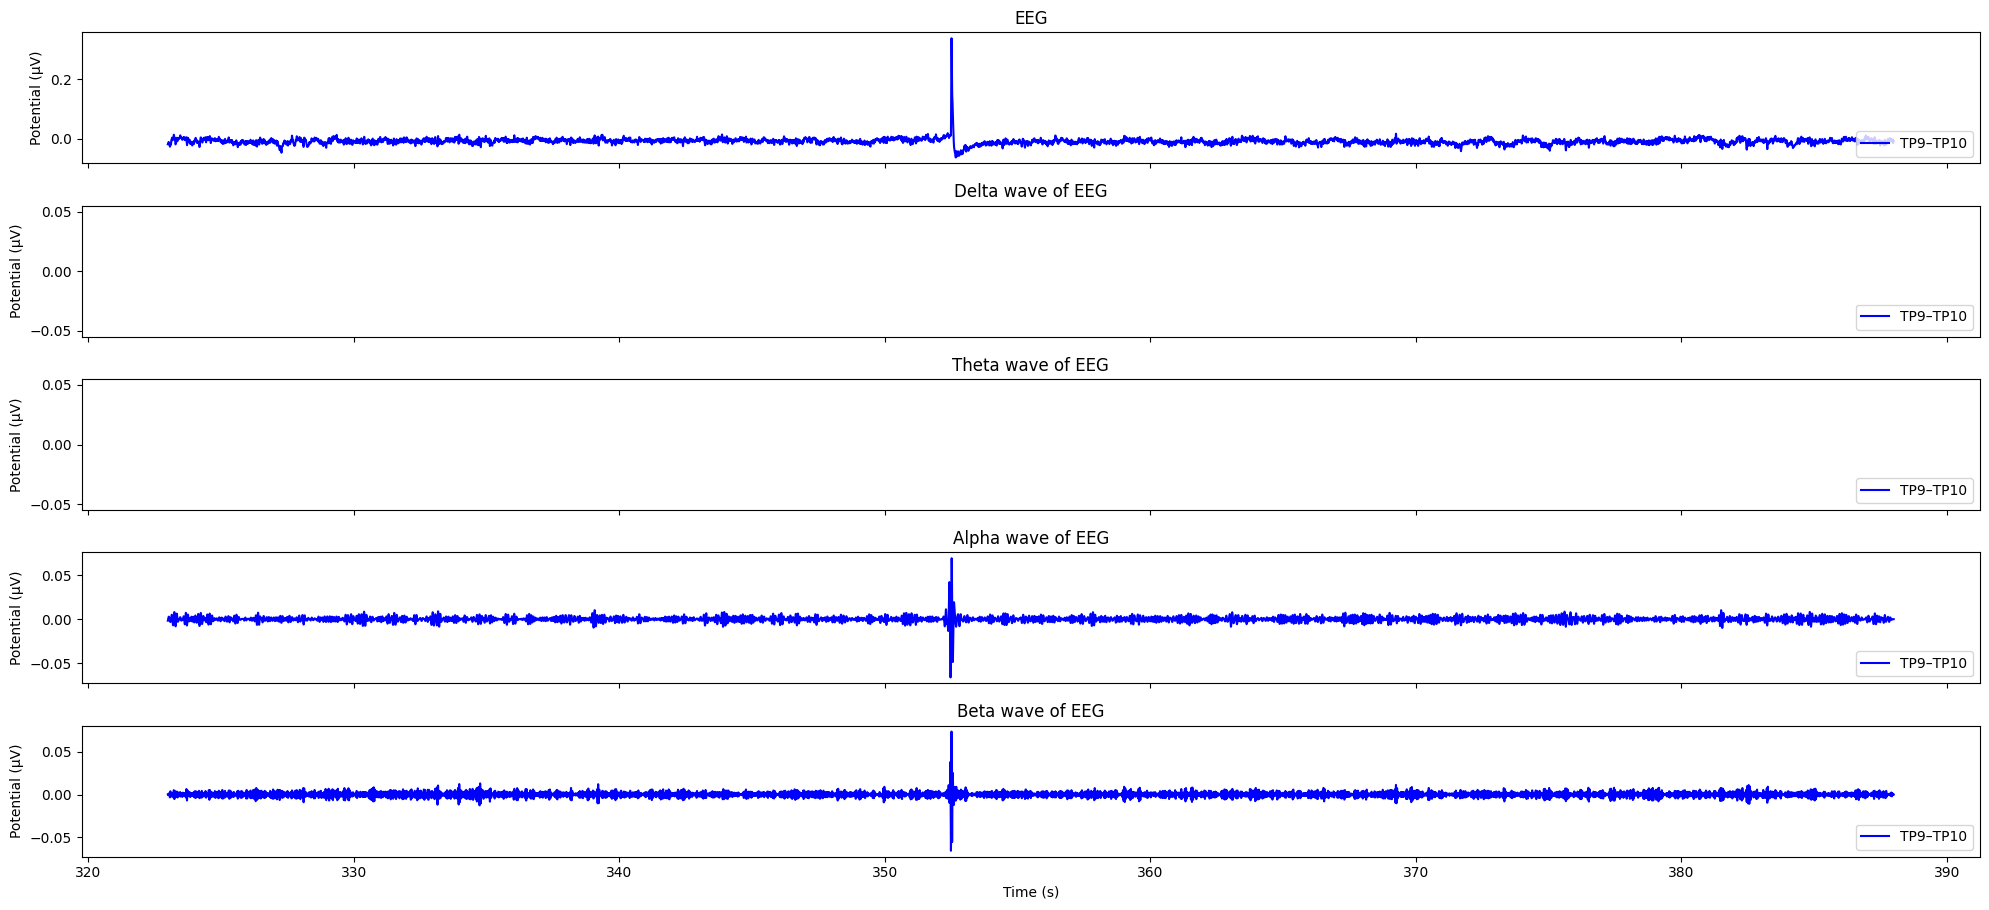

In [21]:
# Frequency bands for EEG waves
FREQUENCY_BANDS = {
    "delta": (0.1, 3),
    "theta": (4, 6.9),
    "alpha": (8, 15),
    "beta": (16, 31)
}

# Bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Read the file
data = bioread.read_file(file_path)

# Extract channels
channels = [data.channels[0], data.channels[1]]
channel_names = ["AF7–AF8", "TP9–TP10"]

# Dictionary to store all variables
eeg_data = {
    "AF7–AF8": {},
    "TP9–TP10": {}
}

# Define start time for cutting
start_time = cut

# Loop through channels
for i, channel in enumerate(channels):
    eeg_signal = channel.data
    sampling_rate = int(channel.samples_per_second)
    time_index = channel.time_index

    # Cut the signal
    eeg_signal_cut = eeg_signal[time_index >= start_time]
    time_index_cut = time_index[time_index >= start_time]

    # Apply bandpass filters to the cut signal
    eeg_delta_wave = bandpass_filter(eeg_signal_cut, *FREQUENCY_BANDS["delta"], sampling_rate)
    eeg_theta_wave = bandpass_filter(eeg_signal_cut, *FREQUENCY_BANDS["theta"], sampling_rate)
    eeg_alpha_wave = bandpass_filter(eeg_signal_cut, *FREQUENCY_BANDS["alpha"], sampling_rate)
    eeg_beta_wave = bandpass_filter(eeg_signal_cut, *FREQUENCY_BANDS["beta"], sampling_rate)

    # Store signals in dictionary
    channel_name = channel_names[i]
    eeg_data[channel_name] = {
        "time_index": time_index_cut,
        "EEG": eeg_signal_cut,
        "Delta": eeg_delta_wave,
        "Theta": eeg_theta_wave,
        "Alpha": eeg_alpha_wave,
        "Beta": eeg_beta_wave
    }

    # List of the EEG variables and corresponding titles
    eeg_variables = [
        ("EEG", eeg_signal_cut),
        ("Delta wave of EEG", eeg_delta_wave),
        ("Theta wave of EEG", eeg_theta_wave),
        ("Alpha wave of EEG", eeg_alpha_wave),
        ("Beta wave of EEG", eeg_beta_wave)
    ]

    # Plotting
    fig, axs = plt.subplots(len(eeg_variables), 1, figsize=(20, 10), sharex=True)

    for j, (title, var) in enumerate(eeg_variables):
        axs[j].plot(time_index_cut, var, label=channel_name, color="blue" if i == 0 else "blue")
        axs[j].set_ylabel("Potential (µV)")
        axs[j].set_title(title)
        axs[j].legend(loc="lower right")
        if j == len(eeg_variables) - 1:
            axs[j].set_xlabel("Time (s)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Convert to DataFrames for easier analysis
eeg_df_af7_af8 = pd.DataFrame({
    "Time (s)": eeg_data["AF7–AF8"]["time_index"],
    "EEG": eeg_data["AF7–AF8"]["EEG"],
    "Delta": eeg_data["AF7–AF8"]["Delta"],
    "Theta": eeg_data["AF7–AF8"]["Theta"],
    "Alpha": eeg_data["AF7–AF8"]["Alpha"],
    "Beta": eeg_data["AF7–AF8"]["Beta"]
})

eeg_df_tp9_tp10 = pd.DataFrame({
    "Time (s)": eeg_data["TP9–TP10"]["time_index"],
    "EEG": eeg_data["TP9–TP10"]["EEG"],
    "Delta": eeg_data["TP9–TP10"]["Delta"],
    "Theta": eeg_data["TP9–TP10"]["Theta"],
    "Alpha": eeg_data["TP9–TP10"]["Alpha"],
    "Beta": eeg_data["TP9–TP10"]["Beta"]
})

# Correlations between EEG and BP signals

-	Total of 10 EEG variables and 4 BP variables, so 4 • 10 = 40 correlations
-	Spearman metric to calculate correlations between variables
-   Frequencies: for EEG 2000 Hz, for BP waveform 100 Hz, and for BP beats 10 Hz, so signals need to be resampled
-	Zero correlations can be ignored (theta and delta waves of EEG)

In [22]:
# Sampling rate for EEG signals
eeg_fs = 2000

# BP signals and sampling rates
bp_signals = {
    "BP": bp,
    "BP sys": bp_sys,
    "BP dia": bp_dia,
    "BP mean": bp_mean
}
bp_fs_mapping = {
    "BP": 100,
    "BP sys": 10,
    "BP dia": 10,
    "BP mean": 10
}

# Common sampling rate for resampling
common_fs = 1000

# Include all EEG variables from both channels
eeg_signals = {
    "AF7–AF8 EEG": eeg_data["AF7–AF8"]["EEG"],
    "AF7–AF8 Delta": eeg_data["AF7–AF8"]["Delta"],
    "AF7–AF8 Theta": eeg_data["AF7–AF8"]["Theta"],
    "AF7–AF8 Alpha": eeg_data["AF7–AF8"]["Alpha"],
    "AF7–AF8 Beta": eeg_data["AF7–AF8"]["Beta"],
    "TP9–TP10 EEG": eeg_data["TP9–TP10"]["EEG"],
    "TP9–TP10 Delta": eeg_data["TP9–TP10"]["Delta"],
    "TP9–TP10 Theta": eeg_data["TP9–TP10"]["Theta"],
    "TP9–TP10 Alpha": eeg_data["TP9–TP10"]["Alpha"],
    "TP9–TP10 Beta": eeg_data["TP9–TP10"]["Beta"]
}

# Initialize DataFrames to store correlations and p-values
correlation_df = pd.DataFrame(index=eeg_signals.keys(), columns=bp_signals.keys())
p_value_df = pd.DataFrame(index=eeg_signals.keys(), columns=bp_signals.keys())

# Loop through EEG and BP signal combinations
for eeg_name, eeg_signal in eeg_signals.items():
    for bp_name, bp_signal in bp_signals.items():
        # Determine the sampling rate for the current BP signal
        bp_fs = bp_fs_mapping[bp_name]
        
        # Resample EEG and BP signals to the common sampling rate
        num_samples_eeg = int(common_fs * (len(eeg_signal) / eeg_fs))
        num_samples_bp = int(common_fs * (len(bp_signal) / bp_fs))
        resampled_eeg = resample(eeg_signal, num_samples_eeg)
        resampled_bp = resample(bp_signal, num_samples_bp)
        
        # Ensure both resampled signals have the same length
        min_length = min(len(resampled_eeg), len(resampled_bp))
        resampled_eeg = resampled_eeg[:min_length]
        resampled_bp = resampled_bp[:min_length]
        
        # Calculate Spearman correlation and p-value
        correlation, p_value = spearmanr(resampled_eeg, resampled_bp)
        
        # Store the correlation and p-value in separate DataFrames
        correlation_df.loc[eeg_name, bp_name] = correlation
        p_value_df.loc[eeg_name, bp_name] = p_value

# Display the correlation and p-value DataFrames
print("Correlations:")
print(correlation_df)
print("\nAccording p-values:")
print(p_value_df)
print("\nLow p-value (p < 0.05) suggests that correlation is statistically significant.\nHigh p-value (p > 0.05) suggests that correlation is not statistically significant.")

Correlations:
                      BP    BP sys    BP dia   BP mean
AF7–AF8 EEG     0.071943   -0.1503 -0.139837 -0.144425
AF7–AF8 Delta        NaN       NaN       NaN       NaN
AF7–AF8 Theta        NaN       NaN       NaN       NaN
AF7–AF8 Alpha  -0.004081  0.000904  0.001618  0.005842
AF7–AF8 Beta   -0.001169  0.004259 -0.001132  0.001996
TP9–TP10 EEG   -0.154539 -0.051374 -0.187051 -0.140057
TP9–TP10 Delta       NaN       NaN       NaN       NaN
TP9–TP10 Theta       NaN       NaN       NaN       NaN
TP9–TP10 Alpha  0.001422   0.00528  0.005001  0.004778
TP9–TP10 Beta    0.00201  0.002361  0.000356   0.00116

According p-values:
                      BP    BP sys    BP dia   BP mean
AF7–AF8 EEG          0.0       0.0       0.0       0.0
AF7–AF8 Delta        NaN       NaN       NaN       NaN
AF7–AF8 Theta        NaN       NaN       NaN       NaN
AF7–AF8 Alpha   0.298093  0.933167  0.880731   0.58804
AF7–AF8 Beta    0.765759  0.692901  0.916385  0.853194
TP9–TP10 EEG         0.0  0.00

In [23]:
# Display only correlations with low p-values
significant_pairs = correlation_df[p_value_df < 0.05]
significant_pairs = significant_pairs.dropna(how='all', axis=0).dropna(how='all', axis=1)
print("Correlations with low p-values:\n")
print(significant_pairs)

Correlations with low p-values:

                    BP    BP sys    BP dia   BP mean
AF7–AF8 EEG   0.071943   -0.1503 -0.139837 -0.144425
TP9–TP10 EEG -0.154539 -0.051374 -0.187051 -0.140057
